# 02. Ice motion maps from OSI-SAF sea ice motion data
Data source:

## Import packages

In [9]:
# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat

# for use in suppressing repeated warnings when mapping w/ shapely
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# path to own functions
sys.path.append('../Libraries_functions/')
from LIB_ASI_SIC_UniB import grab_ASI_SIC, grab_projinfo_SIC
from LIB_geo_func import *
from LIB_geo_plot import *


# OSI SAF sea ice drift
from LIB_OSI_SAF import grab_projinfo_OSISAF, grab_OSISAF_drift

# NSIDC sea ice drift
from LIB_PPdrift_NSIDC0116 import grab_projinfo_PPdrift


%load_ext autoreload
%autoreload 2
# potentially uninstall pyhdf?

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
main_path = '/Volumes/Seagate_Jewell/KenzieStuff/weekly_icemotion_NSDIC/'

ds = xr.open_dataset(main_path + 'icemotion_weekly_nh_25km_20230101_20240303_ql.nc')
ds.close

NSIDC = {}

NSIDC['time'] = ds.time.values
NSIDC['x'] = ds.x.values
NSIDC['y'] = ds.y.values
NSIDC['u'] = ds.u.values
NSIDC['v'] = ds.v.values
NSIDC['proj'] = grab_projinfo_PPdrift(ds)

#========
week = 53
#========

print(NSIDC['time'][week])

2024-01-08 00:00:00


### OSI-SAF sea ice drift

In [46]:

# specify date to import
#============================
date = datetime(2024, 1, 12)
#============================

OSISAF = grab_OSISAF_drift(date = date, 
                          main_path = '/Volumes/Seagate_Jewell/KenzieStuff/OSI-SAF/')




## Make map

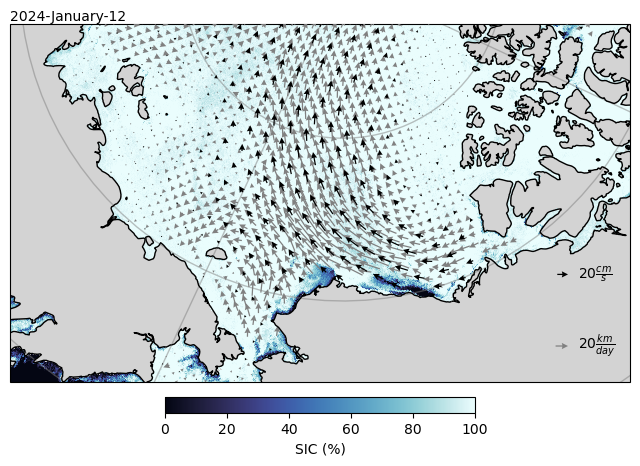

In [47]:

# specify date to plot
#============================
date = datetime(2024, 1, 12)
#============================

# read daily sic data from computer files into dictionary
data = grab_ASI_SIC(date=date, 
                    main_path='/Volumes/Jewell_EasyStore/UniB-ASI-SIC/', 
                    coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
                    hemisphere='n', resolution='6250', version='v5.4', 
                    return_vars=['xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds'], 
                    include_units=False, annual_folders=True, return_dict = True, quiet=True)

# create figure
#--------------
# create map figure in north polar stereographic projection
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=map_projection))

# background color
ax.patch.set_facecolor('lightgray')

# set map extent [lon1, lon2, lat1, lat2]
ax.set_extent([150, 250, 65, 85], crs=ccrs.PlateCarree())  

# add coastlines
ax.coastlines(zorder=100)

# lat / lon lines
add_grid(ax, lats=np.arange(60,90,10), lons=np.arange(0,360,90), linewidth=1, color='gray', alpha=0.5, zorder=4)


# plot 2d sic data 
icec = ax.pcolormesh(data['xx'], data['yy'], data['sic'], 
                     cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])

plt.colorbar(icec, label='SIC (%)', orientation='horizontal', shrink = 0.5, pad=0.025)


# label date
ax.text(0, 1, date.strftime('%Y-%B-%d'), ha='left', va='bottom', transform=ax.transAxes, clip_on=False)


# OSISAF sea ice drift
qv1 = ax.quiver(OSISAF['x'], OSISAF['y'], OSISAF['dx']/2, OSISAF['dy']/2, 
               color = 'gray', width = 0.002, headwidth=5, scale = 1000, transform = OSISAF['proj'], zorder=5)
qk = ax.quiverkey(qv1, 0.9, 0.1, 20, r'$20 \frac{km}{day}$', labelpos='E',transform=ccrs.PlateCarree(),)


# NSIDC sea ice drift
sp = 3
qv2 = ax.quiver(NSIDC['x'][::sp], NSIDC['y'][::sp], NSIDC['u'][week,:,:][::sp,::sp], NSIDC['v'][week,:,:][::sp,::sp], 
               color = 'k', width = 0.002, headwidth=5, scale = 1000*1.15741, transform = NSIDC['proj'], zorder=5)
qk = ax.quiverkey(qv2, 0.9, 0.3, 20, r'$20 \frac{cm}{s}$', labelpos='E',transform=ccrs.PlateCarree(),)


plt.show()


# save figure, if desired
# save_path = f'/Users/jewell/Desktop/map_{date.strftime("%Y-%m-%d")}.png'
# fig.savefig(save_path, dpi=300, bbox_inches = 'tight')

### Create timeseries

In [6]:

all_speeds = np.array([])
all_dates = pd.date_range(start='2023-11-1', end='2024-03-30', freq='D')

for date in all_dates:

    OSISAF = grab_OSISAF_drift(date = date, 
                          main_path = '/Volumes/Seagate_Jewell/KenzieStuff/OSI-SAF/')
    
    x_cr = (20, 35)
    y_cr = (80, 95)

    crop_dx = OSISAF['dx'][y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]]/2
    crop_dy = OSISAF['dy'][y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]]/2
    region_speed = np.sqrt(np.nanmean(crop_dx)**2 + np.nanmean(crop_dy)**2)
    
    all_speeds = np.append(all_speeds, region_speed)


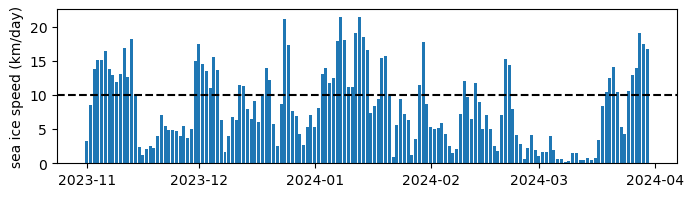

In [7]:
fig, ax = plt.subplots(figsize=(8,2))
ax.bar(all_dates, all_speeds)
ax.set_ylabel('sea ice speed (km/day)')

ax.axhline(10, c='k', linestyle='dashed')